# Exploratory Data Analysis (EDA) — ASX OHLCV Daily (Parquet → Pandas)

**End-to-end OSS Data Lake demo: Airflow/MinIO ingestion + Jupyter/Pandas EDA**  
Generated: **2025-12-16 04:35 UTC**

This notebook assumes a DataFrame named `df` is already available in memory (e.g., loaded from Parquet produced by your Airflow pipeline).  
The goal is to perform a complete, repeatable EDA suitable for validating and showcasing the Data Scientist layer of the stack.

---


## Contents

1. DataFrame Contract (Schema + Required Columns)  
2. Canonical Type Normalisation  
3. High-level Profile (Shape, Uniques, Date Range)  
4. Key Integrity & Duplicates  
5. Nulls & Completeness  
6. Date Coverage & Missing Trading Days (Per Ticker)  
7. OHLCV Sanity Checks  
8. Corporate Action Signal Check (Close vs Adj Close)  
9. Returns & Volatility Diagnostics  
10. Liquidity / Volume Diagnostics  
11. Cross-ticker Correlation (Returns)  
12. Outputs & EDA Summary

---


In [1]:
%pip install pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 2.1 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 6.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.9/16.9 MB 5.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 348.5/348.5 kB 5.3 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install pyarrow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 5.7 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 5.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 355.2/355.2 kB 4.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 6.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 6.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 5.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.9/113.9 kB 4.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [5]:
%pip install minio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.8/93.8 kB 1.9 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 4.7 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [6]:
import io
import pandas as pd
from minio import Minio

# -------------------------------
# MinIO connection (matches your working DAG style)
# -------------------------------
client = Minio(
    "minio:9000",
    access_key="minioadmin",
    secret_key="minioadmin",
    secure=False,
)

BUCKET = "curated"
PREFIX = "tabular/market_ohlcv_daily/exchange=ASX/"   # narrow scope as you did

# -------------------------------
# List parquet objects
# -------------------------------
parquet_keys = [
    obj.object_name
    for obj in client.list_objects(BUCKET, prefix=PREFIX, recursive=True)
    if obj.object_name.endswith(".parquet")
]

print(f"Found {len(parquet_keys)} parquet files under s3://{BUCKET}/{PREFIX}")
print("Sample keys:", parquet_keys[:5])

# -------------------------------
# Read each parquet and concatenate
# (force trade_date to a consistent type to avoid Arrow merge errors)
# -------------------------------
dfs = []
for key in parquet_keys:
    resp = client.get_object(BUCKET, key)
    try:
        data = resp.read()  # bytes
    finally:
        resp.close()
        resp.release_conn()

    part = pd.read_parquet(io.BytesIO(data), engine="pyarrow")

    # Normalise problematic columns if present
    if "trade_date" in part.columns:
        part["trade_date"] = part["trade_date"].astype("string")
    if "exchange" in part.columns:
        part["exchange"] = part["exchange"].astype("string")

    dfs.append(part)

df = pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()

Found 1265 parquet files under s3://curated/tabular/market_ohlcv_daily/exchange=ASX/
Sample keys: ['tabular/market_ohlcv_daily/exchange=ASX/trade_date=2020-12-16/snapshot.parquet', 'tabular/market_ohlcv_daily/exchange=ASX/trade_date=2020-12-17/snapshot.parquet', 'tabular/market_ohlcv_daily/exchange=ASX/trade_date=2020-12-18/snapshot.parquet', 'tabular/market_ohlcv_daily/exchange=ASX/trade_date=2020-12-21/snapshot.parquet', 'tabular/market_ohlcv_daily/exchange=ASX/trade_date=2020-12-22/snapshot.parquet']


In [7]:
# Notebook prerequisites (run once)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 160)

OUT_DIR = Path("./eda_output")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Expectation: df already exists in the kernel
assert "df" in globals(), "Expected a pandas DataFrame named `df` to already exist in memory."


## 1. DataFrame Contract (Schema + Required Columns)

This section confirms the dataset matches the expected grain and minimum schema for daily OHLCV analytics.
If any assertion fails, fix the upstream pipeline first (Airflow/Parquet generation) rather than “patching” the EDA.


In [8]:
required_cols = [
    "dataset_id","exchange","ticker","vendor_symbol","currency","trade_date",
    "open","high","low","close","volume","adj_close",
    "ingest_ts","ingest_batch_id","source_object_key","row_hash"
]

missing = sorted(set(required_cols) - set(df.columns))
assert not missing, f"Missing required columns: {missing}"

df.shape, df.dtypes


((122987, 16),
 dataset_id                        object
 exchange                  string[python]
 ticker                            object
 vendor_symbol                     object
 currency                          object
 trade_date                string[python]
 open                             float64
 high                             float64
 low                              float64
 close                            float64
 volume                             int64
 adj_close                        float64
 ingest_ts            datetime64[ns, UTC]
 ingest_batch_id                   object
 source_object_key                 object
 row_hash                          object
 dtype: object)

## 2. Canonical Type Normalisation

We standardise types used throughout the EDA:
- `trade_date` as `datetime64[ns]` (naive, date-level)
- `ticker` and `exchange` as string categories suitable for grouping
- numeric OHLCV as numeric


In [9]:
df_eda = df.copy()

df_eda["exchange"] = df_eda["exchange"].astype("string")
df_eda["ticker"] = df_eda["ticker"].astype("string")
df_eda["vendor_symbol"] = df_eda["vendor_symbol"].astype("string")
df_eda["currency"] = df_eda["currency"].astype("string")
df_eda["dataset_id"] = df_eda["dataset_id"].astype("string")

df_eda["trade_date"] = pd.to_datetime(df_eda["trade_date"], errors="raise").dt.normalize()

num_cols = ["open","high","low","close","adj_close","volume"]
df_eda[num_cols] = df_eda[num_cols].apply(pd.to_numeric, errors="raise")

df_eda["ingest_ts"] = pd.to_datetime(df_eda["ingest_ts"], errors="raise", utc=True)

df_eda = df_eda.sort_values(["exchange","ticker","trade_date"]).reset_index(drop=True)

df_eda.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122987 entries, 0 to 122986
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   dataset_id         122987 non-null  string             
 1   exchange           122987 non-null  string             
 2   ticker             122987 non-null  string             
 3   vendor_symbol      122987 non-null  string             
 4   currency           122987 non-null  string             
 5   trade_date         122987 non-null  datetime64[ns]     
 6   open               122987 non-null  float64            
 7   high               122987 non-null  float64            
 8   low                122987 non-null  float64            
 9   close              122987 non-null  float64            
 10  volume             122987 non-null  int64              
 11  adj_close          120533 non-null  float64            
 12  ingest_ts          122987 non-

## 3. High-level Profile

A concise overview of dataset size, ticker coverage, and date range to validate that the dataset reflects your intended history window.


In [10]:
profile = pd.Series({
    "rows": len(df_eda),
    "cols": df_eda.shape[1],
    "exchanges": df_eda["exchange"].nunique(),
    "tickers": df_eda["ticker"].nunique(),
    "date_min": df_eda["trade_date"].min(),
    "date_max": df_eda["trade_date"].max(),
    "ingest_ts_min": df_eda["ingest_ts"].min(),
    "ingest_ts_max": df_eda["ingest_ts"].max(),
})

profile


rows                                       122987
cols                                           16
exchanges                                       1
tickers                                       100
date_min                      2020-12-16 00:00:00
date_max                      2025-12-16 00:00:00
ingest_ts_min    2025-12-15 06:28:55.788162+00:00
ingest_ts_max    2025-12-16 05:00:20.220564+00:00
dtype: object

## 4. Key Integrity & Duplicates

The canonical business key for daily OHLCV is:
- `exchange + ticker + trade_date`

We quantify duplicates on this key and at full-row level.


In [11]:
key_cols = ["exchange","ticker","trade_date"]

dup_key = df_eda.duplicated(subset=key_cols).sum()
dup_row = df_eda.duplicated().sum()

pd.Series({
    "duplicate_business_keys": int(dup_key),
    "duplicate_full_rows": int(dup_row),
})


duplicate_business_keys    0
duplicate_full_rows        0
dtype: int64

In [12]:
# Show the most recent duplicate-key examples (if any exist)
dups = df_eda[df_eda.duplicated(subset=key_cols, keep=False)].copy()
dups.sort_values(key_cols + ["ingest_ts"]).tail(20)


,dataset_id,exchange,ticker,vendor_symbol,currency,trade_date,open,high,low,close,volume,adj_close,ingest_ts,ingest_batch_id,source_object_key,row_hash


## 5. Nulls & Completeness

Null rates are computed overall and per ticker. These numbers are often the fastest way to identify upstream extraction issues.


In [13]:
nulls = df_eda.isna().sum().sort_values(ascending=False)
null_rates = (nulls / len(df_eda)).rename("null_rate")

pd.concat([nulls.rename("null_count"), null_rates], axis=1)


,null_count,null_rate
adj_close,2454,0.019953
dataset_id,0,0.000000
ticker,0,0.000000
exchange,0,0.000000
currency,0,0.000000
trade_date,0,0.000000
open,0,0.000000
vendor_symbol,0,0.000000
high,0,0.000000
low,0,0.000000


In [14]:
nulls_by_ticker = (df_eda
    .groupby("ticker")[["open","high","low","close","volume","adj_close"]]
    .apply(lambda g: g.isna().mean())
    .sort_values("close", ascending=False)
)

nulls_by_ticker.head(20)


,open,high,low,close,volume,adj_close
ticker,,,,,,
360,0.0,0.0,0.0,0.0,0.0,0.023734
A2M,0.0,0.0,0.0,0.0,0.0,0.023734
AGL,0.0,0.0,0.0,0.0,0.0,0.023734
AIA,0.0,0.0,0.0,0.0,0.0,0.023734
ALD,0.0,0.0,0.0,0.0,0.0,0.023734
ALL,0.0,0.0,0.0,0.0,0.0,0.000791
ALQ,0.0,0.0,0.0,0.0,0.0,0.023734
ALX,0.0,0.0,0.0,0.0,0.0,0.023734
AMC,0.0,0.0,0.0,0.0,0.0,0.023734


## 6. Date Coverage & Missing Trading Days (Per Ticker)

For each ticker, we compute:
- first and last available date
- number of observed rows
- number of missing business days between start and end (Mon–Fri baseline)

This is a *diagnostic*; it does not attempt to model ASX holidays.


In [15]:
coverage = (df_eda
    .groupby(["exchange","ticker"])
    .agg(
        rows=("trade_date","size"),
        start=("trade_date","min"),
        end=("trade_date","max"),
    )
    .reset_index()
)

coverage["expected_bdays"] = coverage.apply(
    lambda r: len(pd.bdate_range(r["start"], r["end"])),
    axis=1
)
coverage["missing_bdays"] = coverage["expected_bdays"] - coverage["rows"]

coverage.sort_values(["missing_bdays","rows"], ascending=[False, True]).head(20)


,exchange,ticker,rows,start,end,expected_bdays,missing_bdays
55,ASX,NWSLV,1263,2020-12-17,2025-12-15,1303,40
0,ASX,360,1264,2020-12-17,2025-12-16,1304,40
1,ASX,A2M,1264,2020-12-17,2025-12-16,1304,40
2,ASX,AGL,1264,2020-12-17,2025-12-16,1304,40
3,ASX,AIA,1264,2020-12-17,2025-12-16,1304,40
4,ASX,ALD,1264,2020-12-17,2025-12-16,1304,40
6,ASX,ALQ,1264,2020-12-17,2025-12-16,1304,40
7,ASX,ALX,1264,2020-12-17,2025-12-16,1304,40
8,ASX,AMC,1264,2020-12-17,2025-12-16,1304,40
10,ASX,APA,1264,2020-12-17,2025-12-16,1304,40


In [16]:
# Inspect missing business days for a single ticker (top missing-bday case)
row = coverage.sort_values(["missing_bdays","rows"], ascending=[False, True]).iloc[0]
ex, t, start, end = row["exchange"], row["ticker"], row["start"], row["end"]

observed = df_eda[(df_eda["exchange"] == ex) & (df_eda["ticker"] == t)][["trade_date"]].drop_duplicates()
expected = pd.DataFrame({"trade_date": pd.bdate_range(start, end)})
missing = expected.merge(observed, on="trade_date", how="left", indicator=True).query("_merge == 'left_only'").drop(columns="_merge")

ex, t, int(row["missing_bdays"]), missing.head(20)


('ASX',
 'NWSLV',
 40,
     trade_date
 6   2020-12-25
 7   2020-12-28
 11  2021-01-01
 28  2021-01-26
 76  2021-04-02
 77  2021-04-05
 127 2021-06-14
 267 2021-12-27
 268 2021-12-28
 272 2022-01-03
 289 2022-01-26
 346 2022-04-15
 347 2022-04-18
 352 2022-04-25
 387 2022-06-13
 460 2022-09-22
 527 2022-12-26
 528 2022-12-27
 532 2023-01-02
 550 2023-01-26)

## 7. OHLCV Sanity Checks

We perform standard financial series validations:
- `low <= min(open, close) <= max(open, close) <= high`
- prices are non-negative
- volume is non-negative


In [17]:
bad_price = (df_eda[["open","high","low","close","adj_close"]] < 0).any(axis=1).sum()
bad_volume = (df_eda["volume"] < 0).sum()

ohlc_inversion = (
    (df_eda["low"] > df_eda[["open","close"]].min(axis=1)) |
    (df_eda["high"] < df_eda[["open","close"]].max(axis=1)) |
    (df_eda["low"] > df_eda["high"])
).sum()

pd.Series({
    "rows_with_negative_price": int(bad_price),
    "rows_with_negative_volume": int(bad_volume),
    "rows_failing_ohlc_bounds": int(ohlc_inversion),
})


rows_with_negative_price      0
rows_with_negative_volume     0
rows_failing_ohlc_bounds     13
dtype: int64

In [18]:
# Show representative failing rows (if any exist)
fail = df_eda[
    (df_eda[["open","high","low","close","adj_close"]] < 0).any(axis=1) |
    (df_eda["volume"] < 0) |
    ((df_eda["low"] > df_eda[["open","close"]].min(axis=1)) |
     (df_eda["high"] < df_eda[["open","close"]].max(axis=1)) |
     (df_eda["low"] > df_eda["high"]))
].copy()

fail.head(20)


,dataset_id,exchange,ticker,vendor_symbol,currency,trade_date,open,high,low,close,volume,adj_close,ingest_ts,ingest_batch_id,source_object_key,row_hash
12367,market_ohlcv_daily,ASX,ANZ,ANZ.AX,AUD,2024-11-15,31.799999,32.340000,31.760000,32.450001,6684305,30.854368,2025-12-15 08:15:34.431042+00:00,scheduled__2025-12-15T08:10:00+00:00,tabular/market_ohlcv_daily/exchange=ASX/trade_...,5683f4e2536470006e985bd8e211b32fe202aaffd48370...
16433,market_ohlcv_daily,ASX,ASX,ASX.AX,AUD,2025-12-16,56.049999,53.500000,52.169998,52.310001,635544,NaN,2025-12-16 05:00:20.220564+00:00,scheduled__2025-12-16T04:40:00+00:00,tabular/market_ohlcv_daily/exchange=ASX/trade_...,d69a34d87c9ef2c3a60af7829b7da7c38cbbbc16cbc7f1...
18687,market_ohlcv_daily,ASX,BEN,BEN.AX,AUD,2024-11-15,12.640000,12.810000,12.625000,12.820000,592904,12.157832,2025-12-16 05:00:20.220564+00:00,scheduled__2025-12-16T04:40:00+00:00,tabular/market_ohlcv_daily/exchange=ASX/trade_...,6548aae9b891e3e817d70d36d2536ac2002f838d46db82...
21216,market_ohlcv_daily,ASX,BSL,BSL.AX,AUD,2024-11-15,20.760000,20.910000,20.700001,20.950001,428015,20.421942,2025-12-16 05:00:20.220564+00:00,scheduled__2025-12-16T04:40:00+00:00,tabular/market_ohlcv_daily/exchange=ASX/trade_...,fbd42576a6a7ea730b384785b7c479e8fd885b12b842fc...
22481,market_ohlcv_daily,ASX,BXB,BXB.AX,AUD,2024-11-15,19.139999,19.264999,19.120001,19.309999,3521951,18.790520,2025-12-15 08:57:54.142521+00:00,scheduled__2025-12-15T08:50:00+00:00,tabular/market_ohlcv_daily/exchange=ASX/trade_...,cac146359cbfdf63e6efbaeb9b3d1f747486c00352c8da...
25010,market_ohlcv_daily,ASX,CBA,CBA.AX,AUD,2024-11-15,154.000000,154.945007,152.529999,155.130005,2493400,150.657974,2025-12-15 06:47:10.130119+00:00,scheduled__2025-12-15T06:40:00+00:00,tabular/market_ohlcv_daily/exchange=ASX/trade_...,338adf8e7ee844af6699d3588e9eec415c5fa6a4729610...
59666,market_ohlcv_daily,ASX,MGR,MGR.AX,AUD,2024-11-15,2.140000,2.150000,2.120000,2.110000,3771590,2.020316,2025-12-16 05:00:20.220564+00:00,scheduled__2025-12-16T04:40:00+00:00,tabular/market_ohlcv_daily/exchange=ASX/trade_...,c1280b27645e7ee910bdeb8d5c69460e82f3e8eba8bc0c...
72174,market_ohlcv_daily,ASX,NXT,NXT.AX,AUD,2024-11-15,17.139999,17.240000,16.645000,16.639999,1191681,16.639999,2025-12-16 05:00:20.220564+00:00,scheduled__2025-12-16T04:40:00+00:00,tabular/market_ohlcv_daily/exchange=ASX/trade_...,498e4d68eb1d76322ca7ff55ec395063acfcca347de435...
77230,market_ohlcv_daily,ASX,PME,PME.AX,AUD,2024-11-15,207.240005,209.639999,205.600006,209.860001,65929,209.454483,2025-12-16 05:00:20.220564+00:00,scheduled__2025-12-16T04:40:00+00:00,tabular/market_ohlcv_daily/exchange=ASX/trade_...,ed9a53d5f811cc0cf73f1a2e4649711e265cbc5c74f4e8...
79758,market_ohlcv_daily,ASX,QAN,QAN.AX,AUD,2024-11-15,8.650000,8.870000,8.580000,8.890000,7033512,8.446974,2025-12-16 05:00:20.220564+00:00,scheduled__2025-12-16T04:40:00+00:00,tabular/market_ohlcv_daily/exchange=ASX/trade_...,90eebeaf57650109ef6610cd2d0360c5d2cc12eff9282b...


## 8. Corporate Action Signal Check (Close vs Adj Close)

A quick diagnostic: `adj_close` should be strongly correlated with `close` but may differ materially around splits/dividends.
We quantify the absolute and relative difference distribution.


In [19]:
df_eda["adj_diff"] = df_eda["adj_close"] - df_eda["close"]
df_eda["adj_diff_pct"] = df_eda["adj_diff"] / df_eda["close"]

stats = df_eda["adj_diff_pct"].describe(percentiles=[0.01,0.05,0.5,0.95,0.99]).to_frame("adj_diff_pct")
stats


,adj_diff_pct
count,120533.000000
mean,-0.071325
std,0.069279
min,-0.431838
1%,-0.283995
5%,-0.205160
50%,-0.051272
95%,0.000000
99%,0.000000
max,0.000000


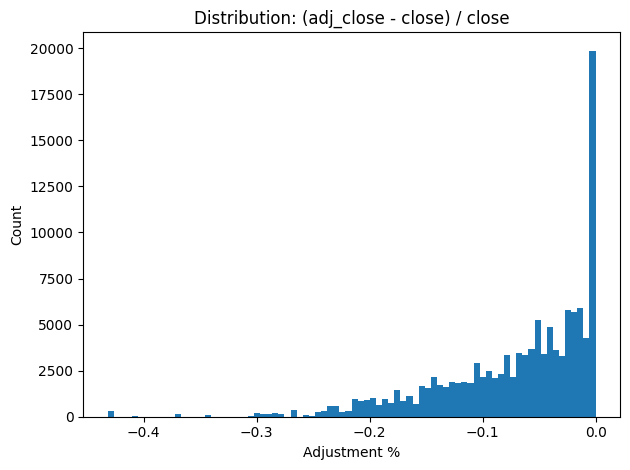

In [20]:
# Histogram of adjustment percentage differences
plt.figure()
plt.hist(df_eda["adj_diff_pct"].dropna(), bins=80)
plt.title("Distribution: (adj_close - close) / close")
plt.xlabel("Adjustment %")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig(OUT_DIR / "adj_close_vs_close_hist.png", dpi=150)
plt.show()


## 9. Returns & Volatility Diagnostics

We compute daily simple returns using `adj_close` (default) to avoid corporate-action distortions.
We then summarise return distribution and identify extreme z-score events.


In [21]:
df_ret = df_eda[["exchange","ticker","trade_date","adj_close","volume"]].copy()
df_ret["ret_1d"] = df_ret.groupby(["exchange","ticker"])["adj_close"].pct_change()

ret_desc = df_ret["ret_1d"].describe(percentiles=[0.01,0.05,0.5,0.95,0.99]).to_frame("ret_1d")
ret_desc


/tmp/ipykernel_9569/2388717895.py:2: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df_ret["ret_1d"] = df_ret.groupby(["exchange","ticker"])["adj_close"].pct_change()


,ret_1d
count,122887.000000
mean,0.000658
std,0.020482
min,-0.294008
1%,-0.053658
5%,-0.028986
50%,0.000000
95%,0.030065
99%,0.057272
max,1.465752


In [22]:
# Identify extreme return events (z-score within each ticker)
def zscore(s: pd.Series) -> pd.Series:
    mu = s.mean()
    sd = s.std(ddof=0)
    return (s - mu) / sd

df_ret["ret_z"] = df_ret.groupby(["exchange","ticker"])["ret_1d"].transform(zscore)

anoms = (df_ret[df_ret["ret_z"].abs() >= 6]
         .sort_values(["ret_z"])
         [["exchange","ticker","trade_date","adj_close","ret_1d","ret_z","volume"]]
        )

anoms.head(30)


,exchange,ticker,trade_date,adj_close,ret_1d,ret_z,volume
61673,ASX,MPL,2022-10-26,2.533210,-0.181170,-14.085709,84425852
103930,ASX,SUN,2025-02-18,18.477015,-0.193672,-13.542728,176104
118877,ASX,WOW,2025-08-27,28.063757,-0.146918,-12.483026,15711381
73760,ASX,ORI,2021-02-26,11.149748,-0.181226,-12.385885,8692161
54149,ASX,JHX,2025-08-20,32.000000,-0.278304,-12.022092,13428379
35313,ASX,CSL,2025-08-19,222.909836,-0.168878,-11.794737,5026031
69592,ASX,NWSLV,2024-02-20,29.726738,-0.230513,-11.455371,56
35363,ASX,CSL,2025-10-28,177.860001,-0.158736,-11.085435,4209921
18749,ASX,BEN,2025-02-17,10.782726,-0.152757,-10.695328,7401862
1265,ASX,A2M,2020-12-18,9.962527,-0.236446,-9.408123,26203979


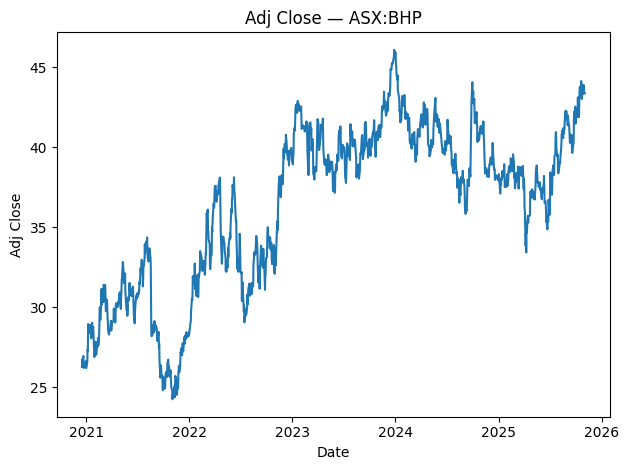

('ASX', 'BHP', 1234)

In [23]:
# Plot adj_close for a representative top-coverage ticker
top = (df_eda.groupby(["exchange","ticker"]).size().sort_values(ascending=False).index[0])
ex, t = top

d = df_eda[(df_eda["exchange"] == ex) & (df_eda["ticker"] == t)][["trade_date","adj_close"]].dropna()

plt.figure()
plt.plot(d["trade_date"], d["adj_close"])
plt.title(f"Adj Close — {ex}:{t}")
plt.xlabel("Date")
plt.ylabel("Adj Close")
plt.tight_layout()
plt.savefig(OUT_DIR / f"adj_close_{ex}_{t}.png", dpi=150)
plt.show()

(ex, t, len(d))


## 10. Liquidity / Volume Diagnostics

Volume tends to be heavy-tailed. We inspect log-volume distribution and per-ticker volume medians.


In [24]:
df_vol = df_eda[["exchange","ticker","trade_date","volume"]].copy()
df_vol["log10_volume"] = np.log10(df_vol["volume"].replace(0, np.nan))

df_vol["log10_volume"].describe(percentiles=[0.01,0.05,0.5,0.95,0.99]).to_frame("log10_volume")


,log10_volume
count,121526.000000
mean,6.133840
std,0.786062
min,0.000000
1%,3.293860
5%,4.770228
50%,6.242182
95%,7.129179
99%,7.443802
max,8.795909


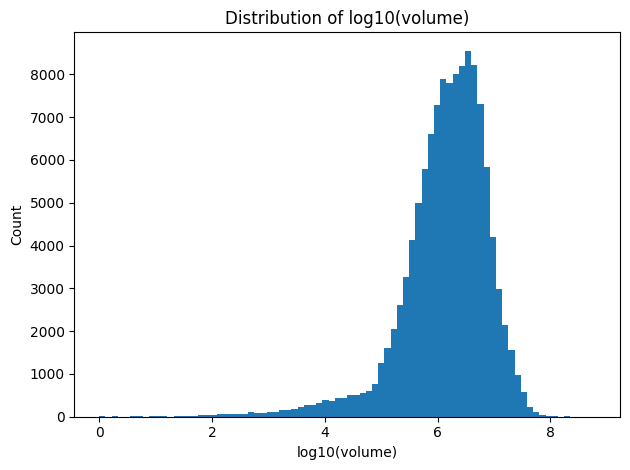

In [25]:
plt.figure()
plt.hist(df_vol["log10_volume"].dropna(), bins=80)
plt.title("Distribution of log10(volume)")
plt.xlabel("log10(volume)")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig(OUT_DIR / "log10_volume_hist.png", dpi=150)
plt.show()


In [26]:
vol_by_ticker = (df_vol.groupby(["exchange","ticker"])["volume"]
                 .median()
                 .sort_values(ascending=False)
                 .to_frame("median_volume"))

vol_by_ticker.head(20)


median_volume
exchange ticker               
ASX      PLS        24088704.5
         TLS        20876798.0
         S32        16600687.0
         MGR        10582338.0
         SCG        10496081.5
         VCX         9472821.0
         STO         8236498.0
         EVN         8016990.0
         BHP         7827471.0
         WHC         6905117.5
         FMG         6797907.0
         QAN         6524928.0
         MPL         6262367.0
         AZJ         5916364.0
         SGP         5688019.5
         WBC         5501940.0
         IAG         5237003.0
         ANZ         5105657.0
         GPT         4753102.0
         NST         4519238.0

## 11. Cross-ticker Correlation (Returns)

We compute a return matrix (date x ticker) and then a correlation matrix. For 100 tickers, this is a strong structural EDA view.


In [27]:
ret_matrix = (df_ret
    .pivot_table(index="trade_date", columns="ticker", values="ret_1d")
    .sort_index()
)

# Keep tickers with at least 80% non-null returns
min_obs = int(ret_matrix.shape[0] * 0.8)
ret_matrix2 = ret_matrix.dropna(axis=1, thresh=min_obs)

corr = ret_matrix2.corr()

ret_matrix.shape, ret_matrix2.shape, corr.shape


((1264, 100), (1264, 96), (96, 96))

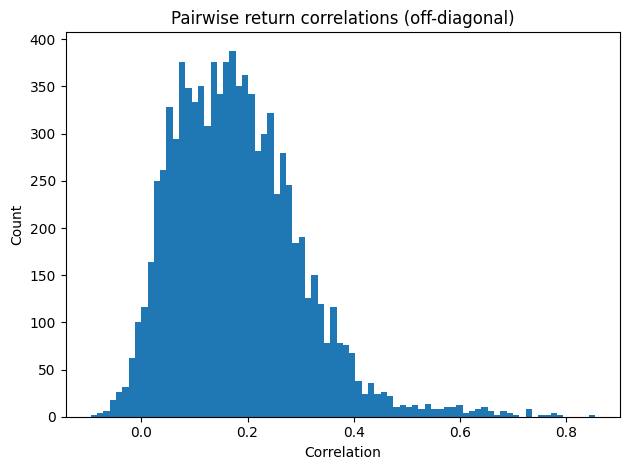

In [28]:
vals = corr.to_numpy()
off_diag = vals[~np.eye(vals.shape[0], dtype=bool)]

plt.figure()
plt.hist(off_diag, bins=80)
plt.title("Pairwise return correlations (off-diagonal)")
plt.xlabel("Correlation")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig(OUT_DIR / "return_corr_hist.png", dpi=150)
plt.show()


## 12. Outputs & EDA Summary

This section writes the key EDA artifacts to `./eda_output/` so results are reproducible and suitable for version control or reporting.


In [29]:
# Tables
profile.to_frame("value").to_csv(OUT_DIR / "profile.csv")

coverage.sort_values(["exchange","ticker"]).to_csv(OUT_DIR / "ticker_coverage.csv", index=False)
nulls.to_frame("null_count").join(null_rates).to_csv(OUT_DIR / "nulls_overall.csv")
nulls_by_ticker.to_csv(OUT_DIR / "nulls_by_ticker.csv")

ret_desc.to_csv(OUT_DIR / "returns_describe.csv")
anoms.to_csv(OUT_DIR / "return_anomalies_z6.csv", index=False)

vol_by_ticker.to_csv(OUT_DIR / "median_volume_by_ticker.csv")
corr.to_csv(OUT_DIR / "returns_correlation.csv")

# Human-readable summary
summary_lines = [
    f"Rows: {len(df_eda):,}",
    f"Tickers: {df_eda['ticker'].nunique():,}",
    f"Date range: {df_eda['trade_date'].min().date()} to {df_eda['trade_date'].max().date()}",
    f"Duplicate business keys (exchange,ticker,trade_date): {int(dup_key):,}",
    f"Rows failing OHLC bounds: {int(ohlc_inversion):,}",
    f"Rows with negative price: {int(bad_price):,}",
    f"Rows with negative volume: {int(bad_volume):,}",
    f"Return anomalies (|z|>=6): {len(anoms):,}",
    f"Correlation matrix tickers (>=80% obs): {corr.shape[0]:,}",
]

(OUT_DIR / "eda_summary.txt").write_text("\n".join(summary_lines), encoding="utf-8")

summary_lines


['Rows: 122,987',
 'Tickers: 100',
 'Date range: 2020-12-16 to 2025-12-16',
 'Duplicate business keys (exchange,ticker,trade_date): 0',
 'Rows failing OHLC bounds: 13',
 'Rows with negative price: 0',
 'Rows with negative volume: 0',
 'Return anomalies (|z|>=6): 137',
 'Correlation matrix tickers (>=80% obs): 96']